In [1]:
%pylab inline
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [2]:
def make_train_test(DIR="../input/"):
    train=pd.read_csv(DIR+"/train2_2016_2017_withy.csv",index_col=0)
    test=pd.read_csv(DIR+"/test2_2016_2017_withy.csv",index_col=0)    
    labels=train['logerror']
    train=train.drop("logerror",axis=1)
    test=test.drop("logerror",axis=1)
    assert (train.columns==test.columns).all()
    return train.astype(np.float32),labels.astype(np.float32),test.astype(np.float32)

In [3]:
%time train,labels,test=make_train_test()
train.shape,labels.shape,test.shape

CPU times: user 1min 8s, sys: 17.5 s, total: 1min 25s
Wall time: 1min 25s


((167888, 112), (167888,), (5970434, 112))

In [4]:
train.values.nbytes/1024**2.,test.values.nbytes/1024.**2

(71.7294921875, 2550.8446044921875)

In [5]:
set(train['year']),set(train['month'])

({2016.0, 2017.0},
 {1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0})

In [6]:
test['year'].value_counts(),test['month'].value_counts()

(Series([], Name: year, dtype: int64), Series([], Name: month, dtype: int64))

In [7]:
test['year']=test.index.map( lambda u: 2016 if u%10==6 else 2017).astype(np.float32)

In [8]:
test['year'].value_counts(),test['month'].value_counts()

(2017.0    2985217
 2016.0    2985217
 Name: year, dtype: int64, Series([], Name: month, dtype: int64))

In [9]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
from sklearn.multiclass import OneVsRestClassifier
import cPickle as pickle
import socket

In [10]:
def get_module():
    modulename='xgboost'
    if modulename not in sys.modules:
        sys.path.insert(0, '/home/spark/software/lz/tmp/a/z/third/xgboost/python-package/build/lib/')        
        import xgboost
    if modulename not in sys.modules:
        raise Exception("module not found")
    m=sys.modules[modulename]
    print m.__version__
    assert m.__file__.startswith("/home/spark/software/lz/tmp/a/z/third"), m.__file__
    return  m,socket.gethostname()
        

In [11]:
files='/tmp/c/xgb_l1f0 /tmp/c/xgb_l1f1 /tmp/c/xgb_l1f2 /tmp/c/xgb_l1f4 /tmp/c/xgb_l1f6 /tmp/c/xgb_l1f7'.split(" ")
files

['/tmp/c/xgb_l1f0',
 '/tmp/c/xgb_l1f1',
 '/tmp/c/xgb_l1f2',
 '/tmp/c/xgb_l1f4',
 '/tmp/c/xgb_l1f6',
 '/tmp/c/xgb_l1f7']

In [12]:
filename=files[1]
filename

'/tmp/c/xgb_l1f1'

In [13]:
import findspark
findspark.init()

In [14]:
from pyspark import SparkContext
from pyspark import SparkConf
from pyspark.sql import SparkSession
conf = SparkConf()
conf.set('spark.executor.cores',1)
conf.set('spark.executor.instances',1) 
conf.set('spark.speculation','true') 
conf.set('spark.driver.memory','40G') 
conf.set('spark.executor.memory','45G') 

#conf.set('spark.cores.max',15)     
conf.setAppName("spark")
conf.setMaster("spark://192.168.0.11:7077")
#conf.setMaster("local")

In [15]:
spark = SparkSession.builder.config(conf=conf).getOrCreate()
sc=spark.sparkContext

In [16]:
len(test.values),test.values.nbytes/1024.0**2

(5970434, 2550.8446044921875)

In [17]:
tests=[test.iloc[:1000000],test.iloc[1000000:2000000],
       test.iloc[2000000:3000000],test.iloc[3000000:4000000]
       ,test.iloc[4000000:5000000],test.iloc[5000000:6000000]]

In [18]:
np.sum([len(u) for u in tests]),[u.values.nbytes/1024.**2 for u in tests]

(5970434,
 [427.24609375,
  427.24609375,
  427.24609375,
  427.24609375,
  427.24609375,
  414.6141357421875])

In [19]:
def load_models(filename):
    while 1:
        tmp=sc.parallelize(range(200),200)
        ips=tmp.map(lambda u:  get_module()[1]).collect()
        print len(set(ips)),
        if len(set(ips))==19:
            break
    models=sc.pickleFile(filename).map(lambda u: (u[0],u[1],pickle.dumps(u[2]))).cache()
    print models.count()
    return models

In [20]:
data=[sc.broadcast(df) for df in tests]

In [21]:
def run_once(models_str):
    xgb=get_module()[0]
    df=pd.concat([u.value for u in data],axis=0).copy()
    models=pickle.loads(models_str)
    preds={}
    for month in [10,11,12]:
        df['month']=month
        d_test = xgb.DMatrix(df.values)
        pred=0
        for m in models:
            pred=pred+m.predict(d_test,ntree_limit=m.best_ntree_limit)
        pred=pred/float(len(models))
        pred=pred.astype(np.float32)
        preds[month]=pred
    return preds

16 16 16 16 16 16 19 95


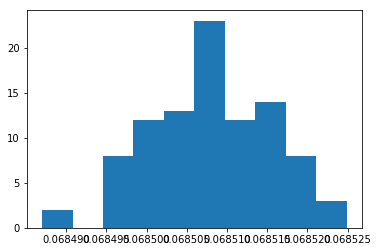

95 0.068508


In [22]:
models=load_models(filename)
scores=models.map(lambda u: u[1]).collect()
plt.hist(scores);plt.show()
print len(scores),np.mean(scores)


In [23]:
predfile=filename+"_preds" 
!hadoop fs -rmr {predfile}

rmr: DEPRECATED: Please use 'rm -r' instead.
17/10/10 01:01:23 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted /tmp/c/xgb_l1f1_preds


In [24]:
this_pred=models.map(lambda u: run_once(u[2]))  

In [25]:
this_pred.saveAsPickleFile(predfile)

In [26]:
sc.stop()